# Force align ground truth transcript to speech file with CTC segmentation algorithm for 1 file

## Basic execution environment setup

In [1]:
import os
import torch
import IPython
import torchaudio
import matplotlib
from dataclasses import dataclass
import matplotlib.pyplot as plt
from Tools import forced_alignment_utils

torch.random.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# %matplotlib inline
matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

## Choose ASR model to use

In [2]:
# model to use
# bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
bundle = torchaudio.pipelines.WAV2VEC2_ASR_LARGE_LV60K_960H

## Specify output folder for results

In [4]:
# folder for saving output wavefiles (and manually plots if needed)
new_dir = "WAV2VEC2_ASR_LARGE_LV60K_960H"
new_dir = os.path.join("/workspace/projects/Alignment/wav2vec2_alignment/single_audio_outputs/forced_aligning", new_dir)
if not os.path.exists(new_dir): os.makedirs(new_dir, exist_ok=True)

## Specify path to <audio, gt_transcript> files

In [6]:
speech_file = r"/workspace/datasets/myst_test/myst_999465_2009-17-12_00-00-00_MS_4.2_024.wav"
transcript_path = r"/workspace/datasets/myst_test/myst_999465_2009-17-12_00-00-00_MS_4.2_024.txt"

# preprocess transcript file
with open(transcript_path, mode="r", encoding="utf-8") as f:
    transcript = f.read().upper().replace(" ", "|")

In [7]:
# generate the label class probability of each audio frame using wav2vec2

model = bundle.get_model().to(device)
labels = bundle.get_labels()
with torch.inference_mode():
    waveform, _ = torchaudio.load(speech_file)
    emissions, _ = model(waveform.to(device))
    emissions = torch.log_softmax(emissions, dim=-1)

# probability of vocab labels at each time step
emission = emissions[0].cpu().detach()

Known vocab: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


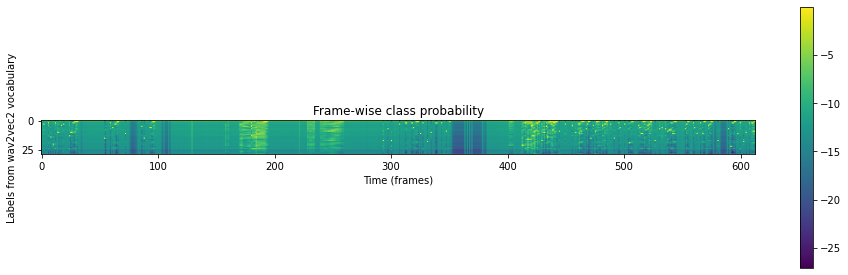

In [8]:
print(f"Known vocab: {labels}")
plt.imshow(emission.T)
plt.colorbar()
plt.title("Frame-wise class probability")
plt.xlabel("Time (frames)")
plt.ylabel("Labels from wav2vec2 vocabulary")
plt.show()

In [9]:
dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))

trellis = forced_alignment_utils.get_trellis(emission, tokens)

[('T', 3), ('E', 2), ('M', 14), ('P', 20), ('E', 2), ('R', 10), ('A', 4), ('T', 3), ('U', 13), ('R', 10), ('E', 2), ('|', 1), ('W', 15), ('E', 2), ('N', 6), ('T', 3), ('|', 1), ('D', 11), ('O', 5), ('W', 15), ('N', 6), ('|', 1), ('U', 13), ('M', 14), ('|', 1), ('F', 17), ('I', 7), ('F', 17), ('T', 3), ('E', 2), ('E', 2), ('N', 6), ('|', 1), ('D', 11), ('E', 2), ('G', 18), ('R', 10), ('E', 2), ('E', 2), ('S', 9), ('|', 1), ('C', 16), ('A', 4), ('U', 13), ('S', 9), ('E', 2), ('|', 1), ('F', 17), ('R', 10), ('O', 5), ('M', 14), ('|', 1), ('S', 9), ('T', 3), ('A', 4), ('R', 10), ('T', 3), ('|', 1), ('I', 7), ('T', 3), ('|', 1), ('W', 15), ('A', 4), ('S', 9), ('|', 1), ('A', 4), ('T', 3), ('|', 1), ('T', 3), ('W', 15), ('E', 2), ('N', 6), ('T', 3), ('Y', 19), ('|', 1), ('A', 4), ('N', 6), ('D', 11), ('|', 1), ('A', 4), ('T', 3), ('|', 1), ('F', 17), ('I', 7), ('N', 6), ('I', 7), ('S', 9), ('H', 8), ('|', 1), ('I', 7), ('T', 3), ('|', 1), ('E', 2), ('N', 6), ('D', 11), ('E', 2), ('D', 11), (

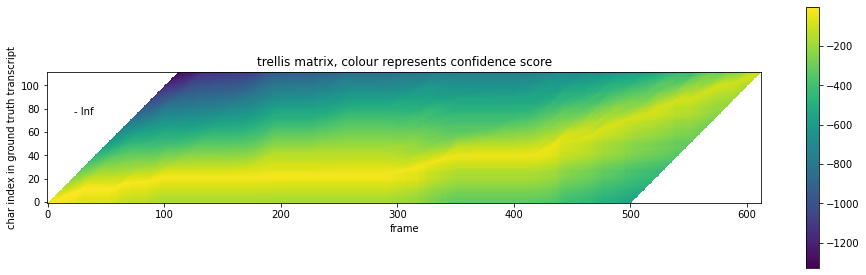

In [10]:
plt.imshow(trellis[1:, 1:].T, origin="lower")
plt.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
plt.colorbar()
plt.title("trellis matrix, colour represents confidence score")
plt.xlabel("frame")
plt.ylabel("char index in ground truth transcript")
plt.show()

In [11]:
path = forced_alignment_utils.backtrack(trellis, emission, tokens)
for p in path:
    print(p)

Point(token_index=0, time_index=2, score=0.9737076163291931)
Point(token_index=0, time_index=3, score=0.9998570680618286)
Point(token_index=0, time_index=4, score=0.9998476505279541)
Point(token_index=0, time_index=5, score=0.9998615980148315)
Point(token_index=1, time_index=6, score=0.9927003979682922)
Point(token_index=1, time_index=7, score=0.9998242259025574)
Point(token_index=2, time_index=8, score=0.9923292994499207)
Point(token_index=2, time_index=9, score=0.9998602867126465)
Point(token_index=3, time_index=10, score=0.9963849782943726)
Point(token_index=3, time_index=11, score=0.9998251795768738)
Point(token_index=4, time_index=12, score=0.9986553192138672)
Point(token_index=4, time_index=13, score=0.9998464584350586)
Point(token_index=5, time_index=14, score=0.9962980151176453)
Point(token_index=5, time_index=15, score=0.9936172962188721)
Point(token_index=5, time_index=16, score=0.9998512268066406)
Point(token_index=6, time_index=17, score=0.9971719980239868)
Point(token_inde

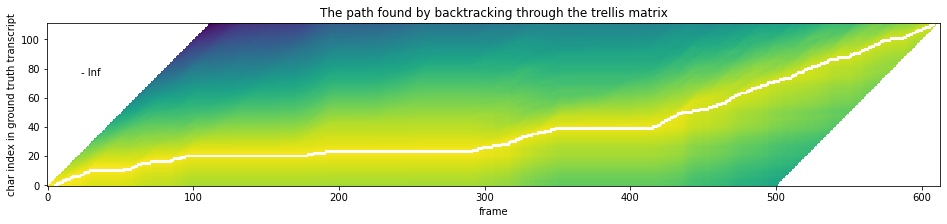

In [12]:
forced_alignment_utils.plot_trellis_with_path(trellis, path)
plt.show()

In [14]:
segments = forced_alignment_utils.merge_repeats(path, transcript)
for seg in segments:
    print(seg)

T	(0.99): [    2,     6)
E	(1.00): [    6,     8)
M	(1.00): [    8,    10)
P	(1.00): [   10,    12)
E	(1.00): [   12,    14)
R	(1.00): [   14,    17)
A	(1.00): [   17,    19)
T	(1.00): [   19,    24)
U	(0.72): [   24,    26)
R	(1.00): [   26,    27)
E	(0.66): [   27,    30)
|	(0.98): [   30,    54)
W	(1.00): [   54,    59)
E	(1.00): [   59,    61)
N	(1.00): [   61,    63)
T	(0.66): [   63,    66)
|	(1.00): [   66,    72)
D	(1.00): [   72,    86)
O	(1.00): [   86,    88)
W	(1.00): [   88,    93)
N	(0.89): [   93,    96)
|	(0.99): [   96,   180)
U	(0.79): [  180,   184)
M	(0.79): [  184,   192)
|	(0.99): [  192,   293)
F	(1.00): [  293,   297)
I	(1.00): [  297,   300)
F	(1.00): [  300,   307)
T	(0.88): [  307,   313)
E	(0.99): [  313,   318)
E	(1.00): [  318,   319)
N	(0.75): [  319,   323)
|	(1.00): [  323,   325)
D	(1.00): [  325,   327)
E	(1.00): [  327,   331)
G	(1.00): [  331,   334)
R	(1.00): [  334,   338)
E	(0.81): [  338,   343)
E	(1.00): [  343,   347)
S	(1.00): [  347,   350)


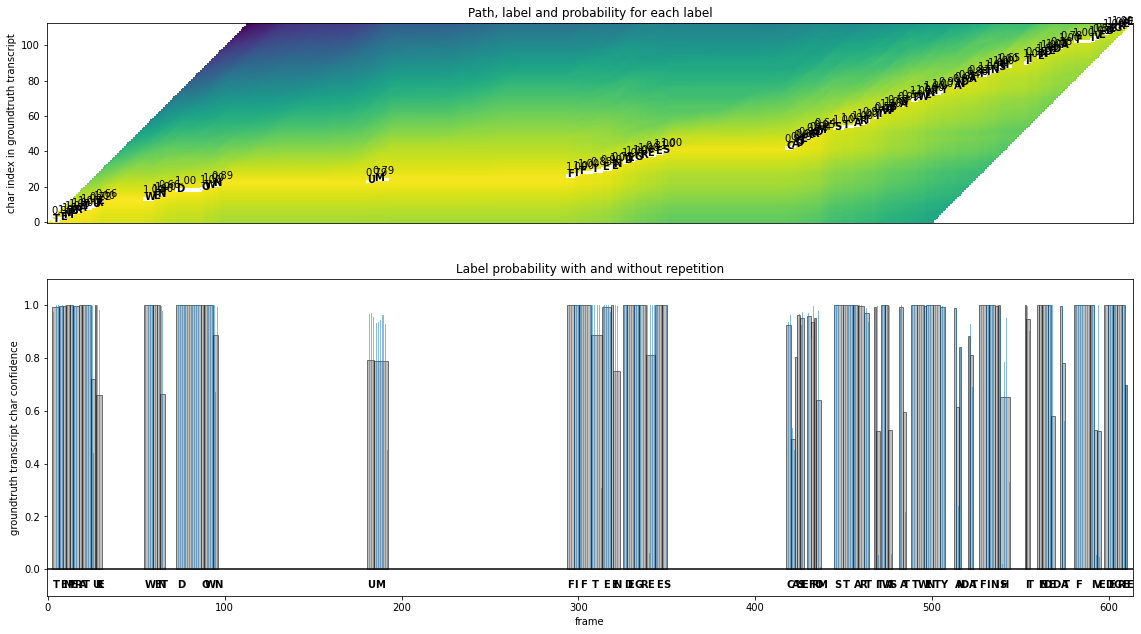

In [16]:
forced_alignment_utils.plot_trellis_with_segments(path, trellis, segments, transcript)
plt.show()

In [17]:
word_segments = forced_alignment_utils.merge_words(segments)
for word in word_segments:
    print(word)

TEMPERATURE	(0.94): [    2,    30)
WENT	(0.91): [   54,    66)
DOWN	(0.99): [   72,    96)
UM	(0.79): [  180,   192)
FIFTEEN	(0.94): [  293,   323)
DEGREES	(0.96): [  325,   350)
CAUSE	(0.84): [  417,   427)
FROM	(0.83): [  429,   437)
START	(0.99): [  444,   464)
IT	(0.68): [  467,   470)
WAS	(0.84): [  471,   477)
AT	(0.79): [  481,   485)
TWENTY	(1.00): [  488,   507)
AND	(0.76): [  512,   516)
AT	(0.83): [  520,   523)
FINISH	(0.88): [  526,   544)
IT	(0.97): [  552,   555)
ENDED	(0.92): [  559,   569)
AT	(0.85): [  572,   575)
FIVE	(0.87): [  580,   595)
DEGREE	(0.98): [  597,   610)


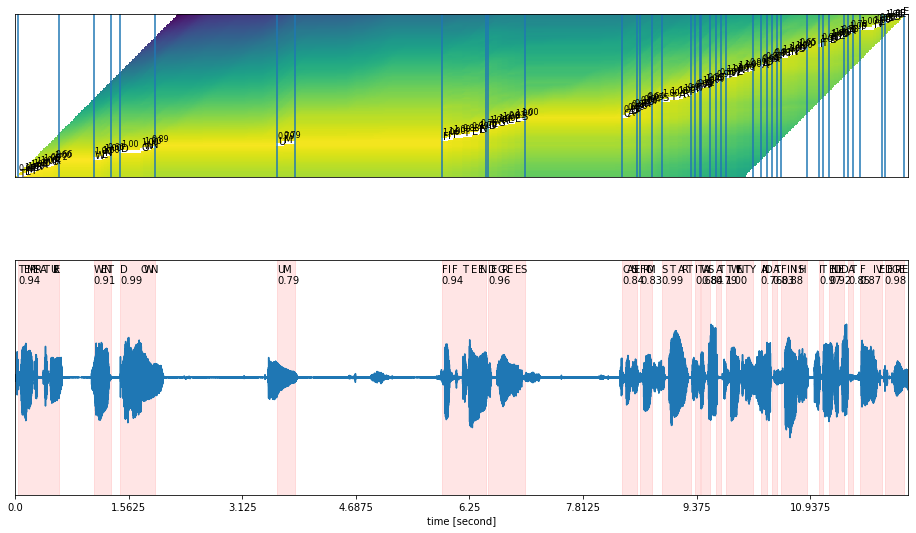

num words: 21


In [18]:
forced_alignment_utils.plot_alignments(
    bundle,
    trellis,
    segments,
    word_segments,
    waveform[0],
)
plt.show()
print("num words: " + str(len(word_segments)))

In [20]:
# A trick to embed the resulting audio to the generated file.
# `IPython.display.Audio` has to be the last call in a cell,
# and there should be only one call par cell.
from scipy.io.wavfile import write

def write_segment(path, i):
    ratio = waveform.size(1) / (trellis.size(0) - 1)
    word = word_segments[i]
    x0 = int(ratio * word.start)
    x1 = int(ratio * word.end)
    print(f"{word.label} ({word.score:.2f}): {x0 / bundle.sample_rate:.3f} - {x1 / bundle.sample_rate:.3f} sec")
    segment = waveform[:, x0:x1]
    torchaudio.save(os.path.join(path, f"segment{i}.wav"), segment, bundle.sample_rate)

# Generate the audio for each segment

for i in range(len(word_segments)):
    segm = write_segment(new_dir, i)

avg_confidence = sum([word.score for word in word_segments]) / len(word_segments)
print(f"Average confidence score across words in ground truth transcript file: {avg_confidence:.3f}")

TEMPERATURE (0.94): 0.040 - 0.601 sec
WENT (0.91): 1.082 - 1.322 sec
DOWN (0.99): 1.442 - 1.923 sec
UM (0.79): 3.606 - 3.847 sec
FIFTEEN (0.94): 5.870 - 6.471 sec
DEGREES (0.96): 6.511 - 7.012 sec
CAUSE (0.84): 8.355 - 8.555 sec
FROM (0.83): 8.595 - 8.755 sec
START (0.99): 8.896 - 9.296 sec
IT (0.68): 9.356 - 9.416 sec
WAS (0.84): 9.437 - 9.557 sec
AT (0.79): 9.637 - 9.717 sec
TWENTY (1.00): 9.777 - 10.158 sec
AND (0.76): 10.258 - 10.338 sec
AT (0.83): 10.418 - 10.478 sec
FINISH (0.88): 10.538 - 10.899 sec
IT (0.97): 11.059 - 11.119 sec
ENDED (0.92): 11.200 - 11.400 sec
AT (0.85): 11.460 - 11.520 sec
FIVE (0.87): 11.620 - 11.921 sec
DEGREE (0.98): 11.961 - 12.221 sec
Average confidence score across words in ground truth transcript file: 0.885
